In [3]:
import os, sys
import time
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

import matplotlib.pyplot as plt
import numpy as np
import cv2

import matplotlib.patches as patches
from sklearn.metrics import jaccard_similarity_score
import warnings
warnings.filterwarnings('ignore')

sys.path.append("../src")

In [4]:
%load_ext autoreload
%autoreload 2

from aisky_util import data_loader
from util import AverageMeter
from fcn_model import CAM_MIL

In [5]:
class Arguments:
    batch_size = 1
    num_epochs = 10
    dataset = "AiSky"
    snapshot_dir = "../ckpt/expr_aisky_adam_0.001"
    restore_from = "AiSky_epoch_9_glo_step_7140.pth.tar"

args = Arguments()
device = "cuda"

In [4]:
def save_checkpoint(args, state, filename='checkpoint.pth.tar'):
    savepath = os.path.join(args.snapshot_dir, filename)
    torch.save(state, savepath)
    #if is_best:
    #    shutil.copyfile(savepath, os.path.join(args.snapshot_dir, 'model_best.pth.tar'))

def train(args):
    
    since = time.time()

    # FCN Model init
    model = CAM_MIL().cuda()
    
    # Backbone resnet for feature extraction
    model_fcn = torchvision.models.resnet152(pretrained=True)
    for param in model_fcn.parameters():
        param.requires_grad = False
    model_fcn = nn.Sequential(*list(model_fcn.children())[:-2]).cuda()
    model_fcn.eval()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    global_counter = 0

    dataloaders = data_loader(args)
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.5)
    
    for epoch in range(args.num_epochs):
        print('Epoch {}/{}'.format(epoch, args.num_epochs - 1))
        print('-' * 10)
        
        running_loss = AverageMeter()
        running_mil_loss = AverageMeter()
        running_cls_loss = AverageMeter()
        running_acc = AverageMeter()
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss.reset()
            running_mil_loss.reset()
            running_cls_loss.reset()
            running_acc.reset()

            # Iterate over data.
            # for inputs, labels in dataloaders[phase]:
            for batch_id, (imgT, targetT) in enumerate(dataloaders[phase]):
                global_counter += 1
                inputs = imgT.to(device)
                labels = torch.FloatTensor([t["label"] for t in targetT])[:, None].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    img_feat = model_fcn(inputs)
                    outputs = model(img_feat, labels)
                    loss, loss_cls, loss_mil = model.get_loss(outputs, labels)
                    cls_logits, att_maps = outputs
                    _, class_pred = torch.max(cls_logits, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss.update(loss.item(), inputs.size(0))
                running_cls_loss.update(loss_cls.item(), inputs.size(0))
                running_mil_loss.update(loss_mil.item(), inputs.size(0))
                running_acc.update(torch.mean((class_pred == (torch.squeeze(labels.data, dim=1))).double()), inputs.size(0))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss.avg
            epoch_cls_loss = running_cls_loss.avg
            epoch_mil_loss = running_mil_loss.avg
            epoch_acc = running_acc.avg

            print('{} Loss: {:.4f} Loss_CLS: {:.4f} Loss_MIL: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_cls_loss, epoch_mil_loss, epoch_acc))

            # Save checkpnt
            save_checkpoint(args,
                            {'epoch': epoch,
                             'arch': 'fcn',
                             'global_counter': global_counter,
                             'state_dict': model.state_dict(),
                             'optimizer': optimizer.state_dict()},
                           filename='%s_epoch_%d_glo_step_%d.pth.tar' %(args.dataset, epoch, global_counter))
            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [9]:
train(args)

Epoch 0/9
----------
train Loss: 0.7227 Loss_CLS: 0.3430 Loss_MIL: 0.3797 Acc: 0.8462
val Loss: 0.4980 Loss_CLS: 0.2924 Loss_MIL: 0.2056 Acc: 0.8729

Epoch 1/9
----------
train Loss: 0.4701 Loss_CLS: 0.2934 Loss_MIL: 0.1767 Acc: 0.8740
val Loss: 0.4228 Loss_CLS: 0.2755 Loss_MIL: 0.1473 Acc: 0.8821

Epoch 2/9
----------
train Loss: 0.4188 Loss_CLS: 0.2817 Loss_MIL: 0.1371 Acc: 0.8786
val Loss: 0.3854 Loss_CLS: 0.2659 Loss_MIL: 0.1195 Acc: 0.8880

Epoch 3/9
----------
train Loss: 0.3843 Loss_CLS: 0.2690 Loss_MIL: 0.1153 Acc: 0.8864
val Loss: 0.3785 Loss_CLS: 0.2740 Loss_MIL: 0.1045 Acc: 0.8835

Epoch 4/9
----------
train Loss: 0.3681 Loss_CLS: 0.2663 Loss_MIL: 0.1018 Acc: 0.8870
val Loss: 0.3480 Loss_CLS: 0.2549 Loss_MIL: 0.0931 Acc: 0.8939

Epoch 5/9
----------
train Loss: 0.3503 Loss_CLS: 0.2584 Loss_MIL: 0.0919 Acc: 0.8930
val Loss: 0.3378 Loss_CLS: 0.2524 Loss_MIL: 0.0855 Acc: 0.8947

Epoch 6/9
----------
train Loss: 0.3417 Loss_CLS: 0.2577 Loss_MIL: 0.0839 Acc: 0.8927
val Loss: 0.32

CAM_MIL(
  (cam_conv): Conv2d(2048, 2, kernel_size=(1, 1), stride=(1, 1))
  (classifier): Sequential(
    (0): ReLU(inplace=True)
    (1): AvgPool2d(kernel_size=7, stride=7, padding=0)
  )
  (cls_loss): CrossEntropyLoss()
)

In [13]:
def val(args, model=None, current_epoch=0):

    if model is None:
        model = CAM_MIL().cuda()
        ckpt_path = os.path.join(args.snapshot_dir, args.restore_from)
        checkpoint = torch.load(ckpt_path)
        model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    
    # Backbone resnet for feature extraction
    model_fcn = torchvision.models.resnet152(pretrained=True)
    for param in model_fcn.parameters():
        param.requires_grad = False
    model_fcn = nn.Sequential(*list(model_fcn.children())[:-2]).cuda()
    model_fcn.eval()

    dataloaders = data_loader(args, test_path=True)

    global_counter = 0
    prob = None
    gt = None
    for idx, dat in enumerate(dataloaders["test"]):

        if idx > 50:
            break
        
        imgT, targetT = dat
        inputs = imgT.to(device)
        labels = torch.FloatTensor([t["label"] for t in targetT])[:, None].to(device)

        img_feat = model_fcn(inputs)
        outputs = model(img_feat, labels)
        loss, loss_cls, loss_mil = model.get_loss(outputs, labels)
        cls_logits, att_maps = outputs
        _, class_pred = torch.max(cls_logits, 1)
        
        if class_pred.item() == 1.0 and labels.item() == 1.0:

            
            # Calculate IOU
            target_mask = np.zeros((224, 224))
            img_cpu = imgT[0].cpu().permute(1,2,0)
            plt.figure(figsize=(9, 36), dpi=80)
            plt.subplot(1,4,1)
            plt.title("Raw Image")
            plt.imshow(img_cpu)
            ax = plt.gca()
            for bbox in targetT[0]["bboxs"]:
                rect = patches.Rectangle((bbox.x1, bbox.y1), bbox.w, bbox.h, linewidth=2, edgecolor='lawngreen', facecolor='none', label="%.2f"%0.0)
                target_mask[int(bbox.y1):int(bbox.y2), int(bbox.x1):int(bbox.x2)] = 1.0
                ax.add_patch(rect)
            #plt.show()
            plt.subplot(1,4,2)
            plt.title("Target Mask")
            plt.imshow(target_mask)
            #plt.show()
            
            heat_map = att_maps[0][0].cpu().data.numpy()
            heat_map = cv2.resize(heat_map, (224, 224))
            norm_heat_map = (heat_map - heat_map.min()) / (heat_map.max() - heat_map.min())
            plt.subplot(1,4,3)
            plt.title("Heatmap")
            plt.imshow(norm_heat_map)
            plt.subplot(1,4,4)
            seg_mask = (norm_heat_map >= 0.8).astype(np.float)
            plt.title("Image w/t SegMask")
            plt.imshow(img_cpu)
            plt.imshow(seg_mask, cmap="plasma", alpha=0.5)
            plt.show()


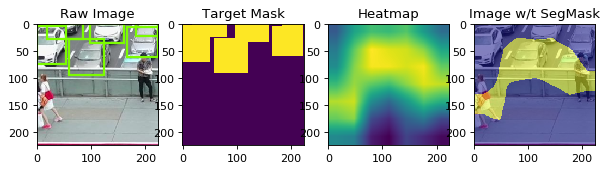

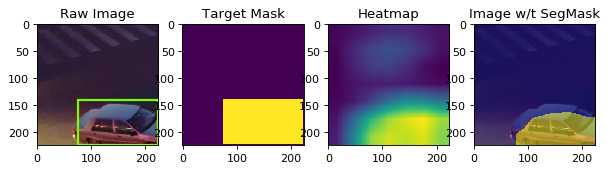

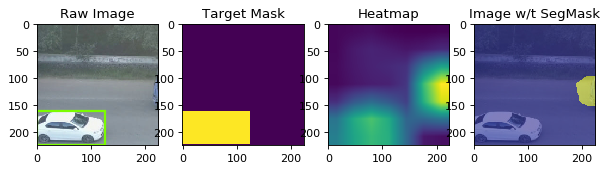

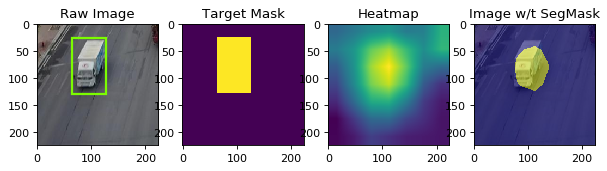

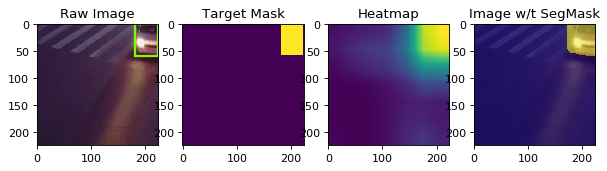

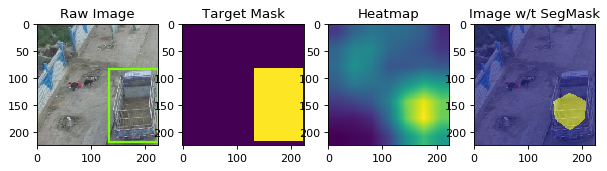

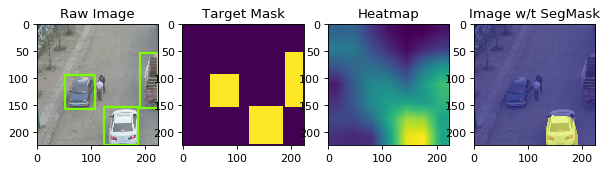

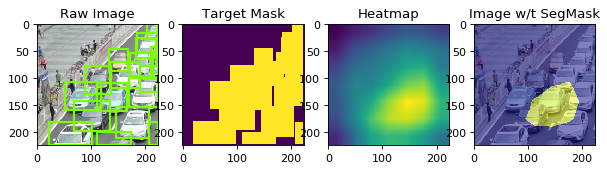

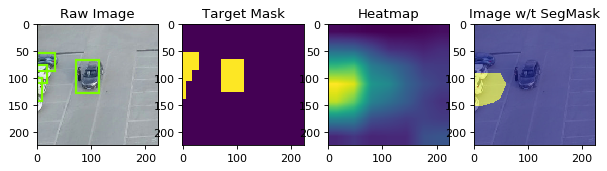

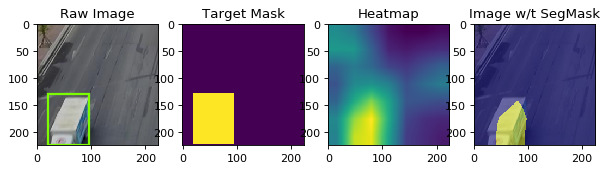

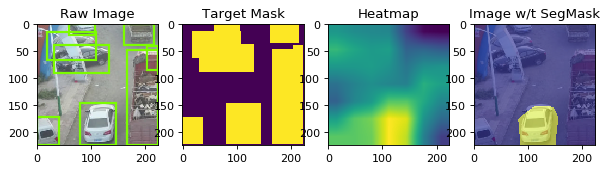

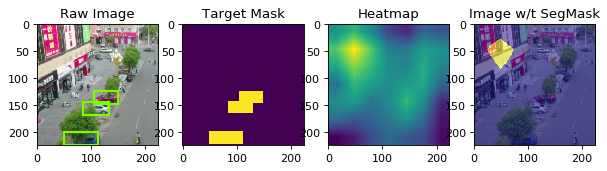

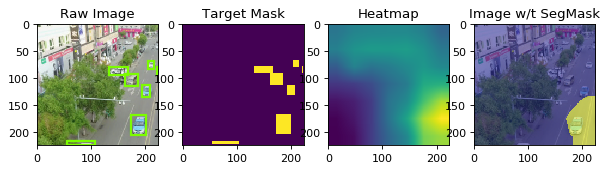

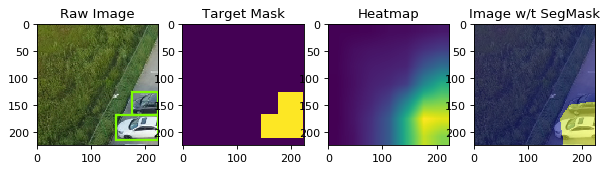

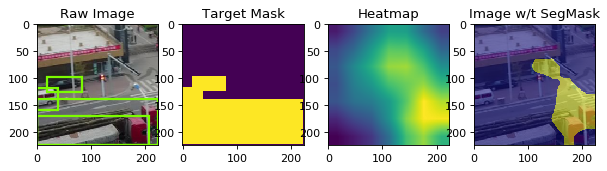

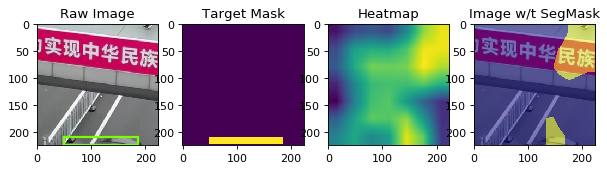

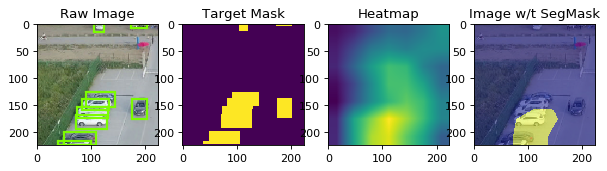

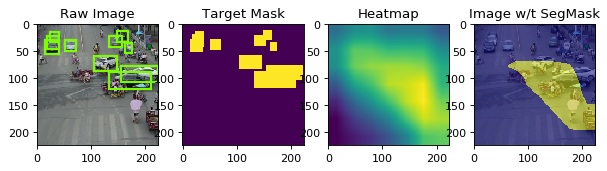

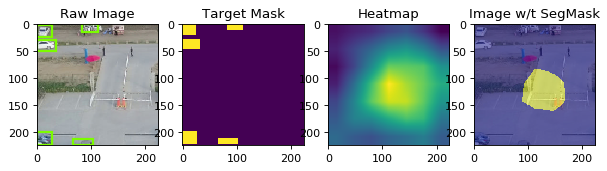

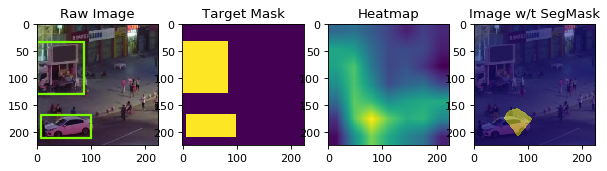

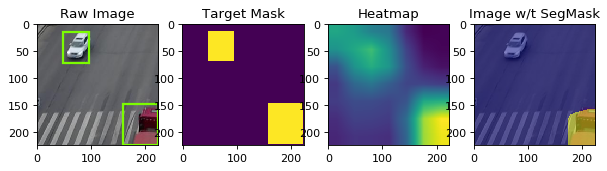

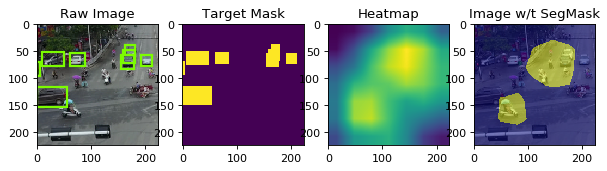

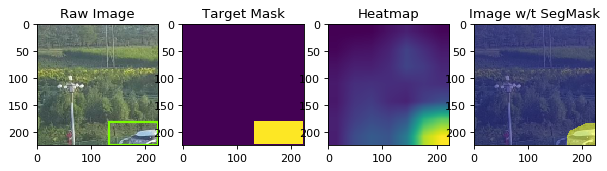

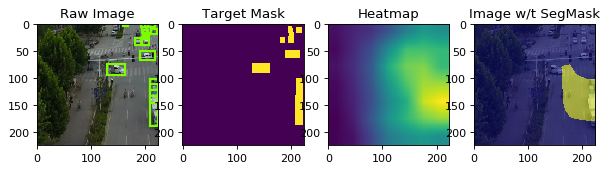

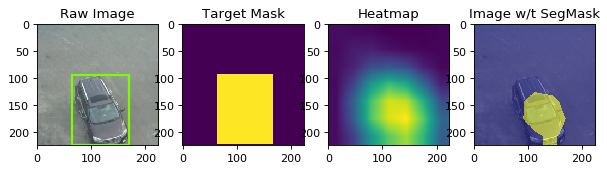

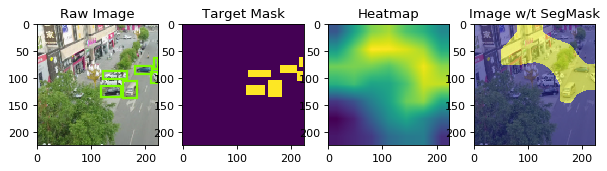

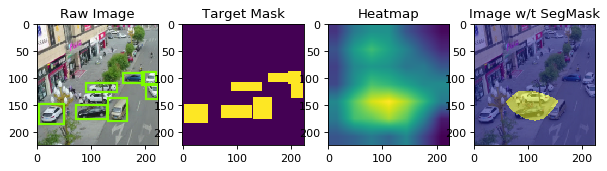

In [14]:
val(args)

In [11]:
def val_metric(args, model=None, current_epoch=0):

    tot_loss = AverageMeter()
    top1 = AverageMeter()
    IOU_score = AverageMeter()
    tot_loss.reset()
    top1.reset()
    IOU_score.reset()

    if model is None:
        model = CAM_MIL().cuda()
        ckpt_path = os.path.join(args.snapshot_dir, args.restore_from)
        checkpoint = torch.load(ckpt_path)
        model.load_state_dict(checkpoint["state_dict"])
    model.eval()
    
    # Backbone resnet for feature extraction
    model_fcn = torchvision.models.resnet152(pretrained=True)
    for param in model_fcn.parameters():
        param.requires_grad = False
    model_fcn = nn.Sequential(*list(model_fcn.children())[:-2]).cuda()
    model_fcn.eval()

    dataloaders = data_loader(args, test_path=True)

    global_counter = 0
    prob = None
    gt = None
    for idx, dat in enumerate(dataloaders["test"]):
        
        imgT, targetT = dat
        inputs = imgT.to(device)
        labels = torch.FloatTensor([t["label"] for t in targetT])[:, None].to(device)

        img_feat = model_fcn(inputs)
        outputs = model(img_feat, labels)
        loss, loss_cls, loss_mil = model.get_loss(outputs, labels)
        cls_logits, att_maps = outputs
        _, class_pred = torch.max(cls_logits, 1)
        
        tot_loss.update(loss.item(), 1)
        if class_pred.item() == labels.item():
            top1.update(1, 1)
        else:
            top1.update(0, 1)
        
        if class_pred.item() == 1.0 and labels.item() == 1.0:
            
            # Calculate IOU
            target_mask = np.zeros((224, 224))
            for bbox in targetT[0]["bboxs"]:
                target_mask[int(bbox.y1):int(bbox.y2), int(bbox.x1):int(bbox.x2)] = 1.0
            
            heat_map = att_maps[0][0].cpu().data.numpy()
            heat_map = cv2.resize(heat_map, (224, 224))
            norm_heat_map = (heat_map - heat_map.min()) / (heat_map.max() - heat_map.min())
            seg_mask = (norm_heat_map >= 0.5).astype(np.float)
            
            iou_score = jaccard_similarity_score(seg_mask, target_mask)
            #print("IOU score:", iou_score)
            IOU_score.update(iou_score, 1)

    print("Testing Loss: %.4f\tAcc: %.3f\tIOU_score: %.3f" % (tot_loss.avg, top1.avg, IOU_score.avg))

In [12]:
val_metric(args)

Testing Loss: 0.4561	Acc: 0.857	IOU_score: 0.421
